In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cleandata import add_impact_score, get_data, plot_grouped_impact_scores, remove_outliers

In [3]:
df = get_data()
df = add_impact_score(df)
df = remove_outliers(df)

c:\Users\iwell\Desktop\qs80\cleandata.py:8: DtypeWarning: Columns (29,30,35,44,45,50,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('80QS.csv')


Removed 51 outliers with impact score above 15099.488000000012
up: 51, new: 25307
new: 25358


c:\Users\iwell\Desktop\qs80\cleandata.py:205: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='años de graduación', y='impact_score',


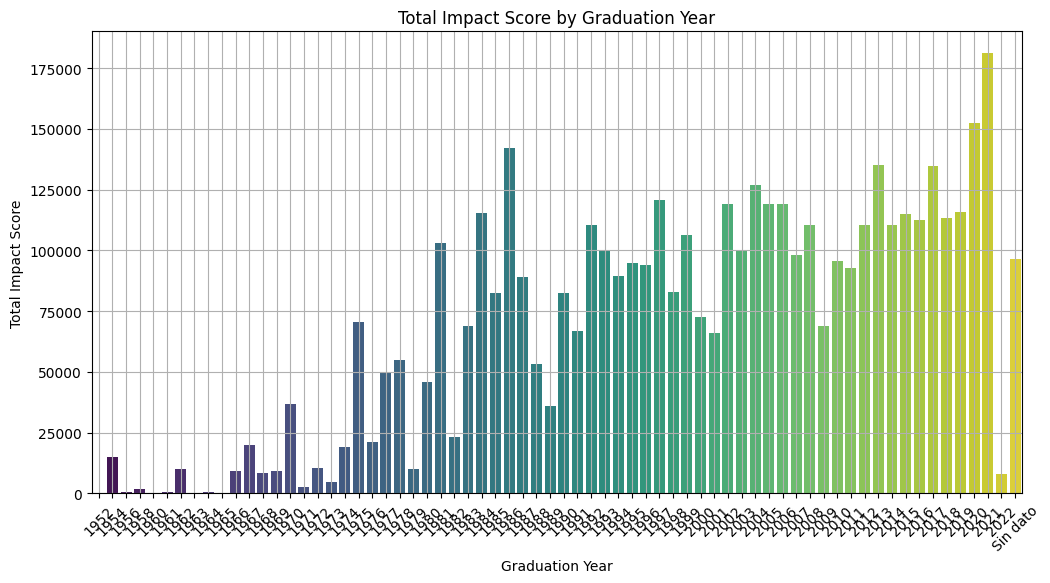

In [4]:
plot_grouped_impact_scores(df)

c:\Users\iwell\Desktop\qs80\cleandata.py:8: DtypeWarning: Columns (29,30,35,44,45,50,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('80QS.csv')


Removed 51 outliers with impact score above 15099.488000000012
up: 51, new: 25307
new: 25358
Rows remaining after filtering: 25011


c:\Users\iwell\Desktop\qs80\cleandata.py:205: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='años de graduación', y='impact_score',


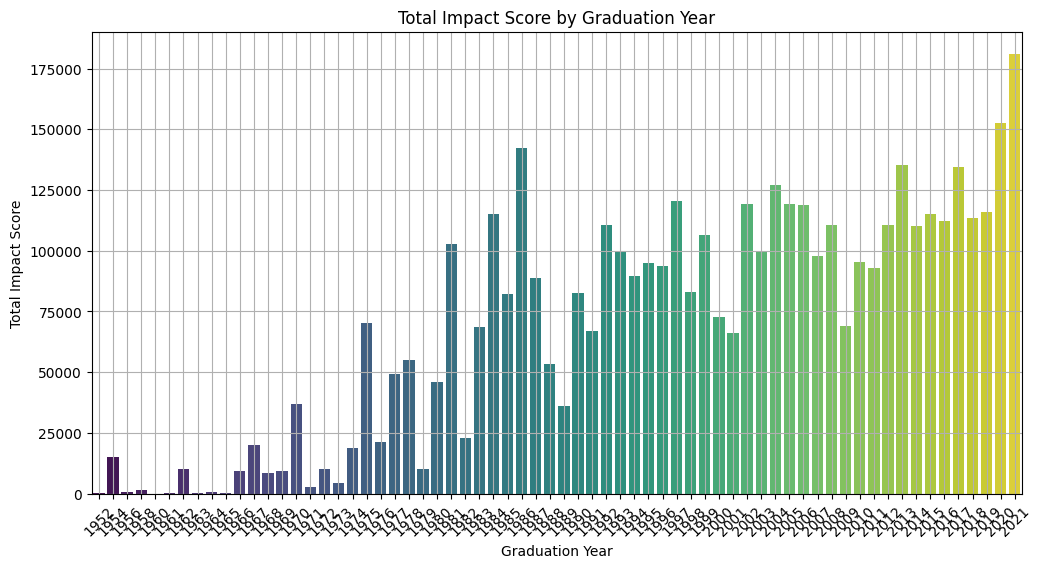

In [28]:
# First, let's reload the data to see what we're working with
df = get_data()
df = add_impact_score(df)
df = remove_outliers(df)

# Check the unique values in graduation year column
# print("Unique graduation years:")
# print(df['años de graduación'].value_counts())
# print(f"\nTotal rows before filtering: {len(df)}")

# Check how many rows would be removed
# rows_to_remove = df[(df['años de graduación'] == 2022) | (df['años de graduación'] == 'Sin dato')]
# print(f"Rows that would be removed: {len(rows_to_remove)}")

# Apply the filter
df_filtered = df[~((df['años de graduación'] == '2022') |
                   (df['años de graduación'] == 'Sin dato'))]
print(f"Rows remaining after filtering: {len(df_filtered)}")

# Plot with the filtered data
if len(df_filtered) > 0:
    plot_grouped_impact_scores(df_filtered)
else:
    print("No data remaining after filtering. Consider adjusting the filter criteria.")

In [7]:
print(1, len(pd.read_csv('80QS.csv')))
print(2, len(df_filtered))

1 25358
2 25011


C:\Users\iwell\AppData\Local\Temp\ipykernel_27992\3447309226.py:1: DtypeWarning: Columns (29,30,35,44,45,50,55) have mixed types. Specify dtype option on import or set low_memory=False.
  print(1, len(pd.read_csv('80QS.csv')))


C:\Users\iwell\AppData\Local\Temp\ipykernel_27992\1316195197.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=X, y=Y, palette='viridis')


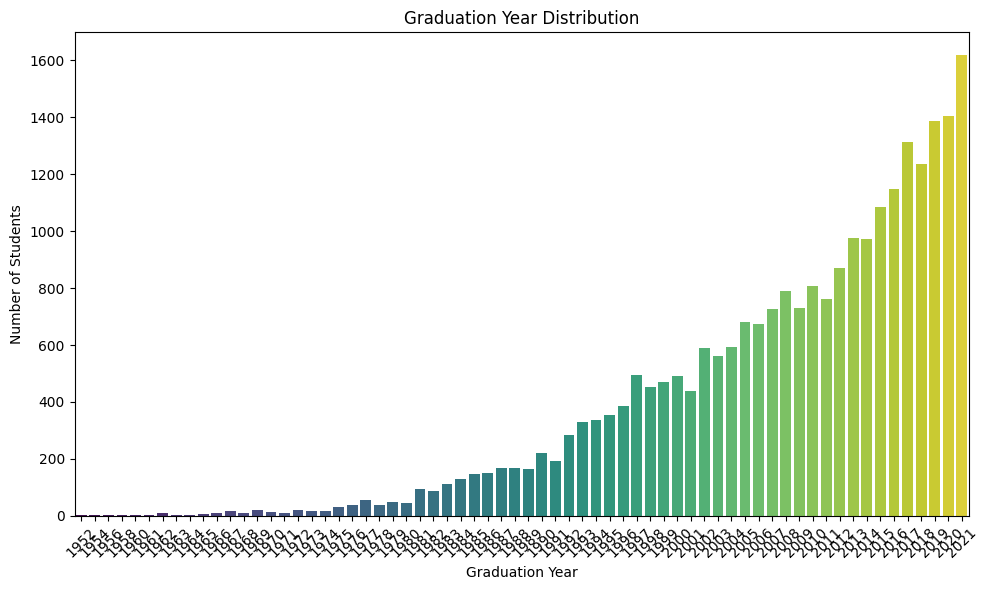

In [27]:
X, Y = np.unique(df_filtered['años de graduación'], return_counts=True)
plt.figure(figsize=(10, 6))
sns.barplot(x=X, y=Y, palette='viridis')
plt.title('Graduation Year Distribution')
plt.xlabel('Graduation Year')
plt.ylabel('Number of Students')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('graduation_year_distribution.png')
plt.show()

Mean Squared Error: 991669812.6316382
R-squared: 0.7280112731055086


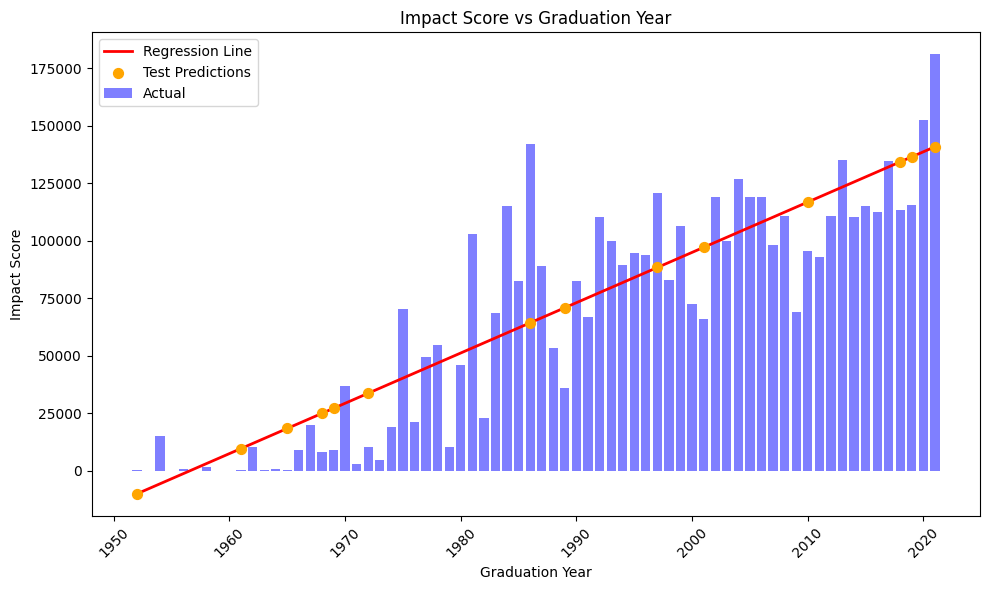

In [ ]:
# Regression models
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Prepare the data for regression
grouped = df_filtered.groupby('años de graduación')[
    'impact_score'].sum().reset_index()
X = grouped['años de graduación'].values.reshape(-1, 1)
y = grouped['impact_score'].values
# Convert years to numeric values
X = X.astype(float)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
# Create and fit the model
model = LinearRegression()
model.fit(X_train, y_train)
# Make predictions
y_pred = model.predict(X_test)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')
# Plot the regression results
plt.figure(figsize=(10, 6))
# Plot actual data as bars
plt.bar(X.flatten(), y, color='blue', alpha=0.5, label='Actual')
# Plot regression line
X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_range_pred = model.predict(X_range)
plt.plot(X_range.flatten(), y_range_pred, color='red',
         linewidth=2, label='Regression Line')
# Plot test predictions
plt.scatter(X_test.flatten(), y_pred, color='orange',
            s=50, label='Test Predictions', zorder=5)
plt.title('Impact Score vs Graduation Year')
plt.xlabel('Graduation Year')
plt.ylabel('Impact Score')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('impact_score_vs_graduation_year.png')
plt.show()

Grouped Data for ARIMA:
                    impact_score
años de graduación              
1952-01-01               240.000
1954-01-01             15099.488
1956-01-01               740.000
1958-01-01              1710.000
1960-01-01                40.000


C:\Users\iwell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\iwell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\iwell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g

ARIMA Forecast for the next 5 years:
66    157600.328119
67    161878.425851
68    145821.026857
69    135774.131733
70    162591.911358
Name: predicted_mean, dtype: float64


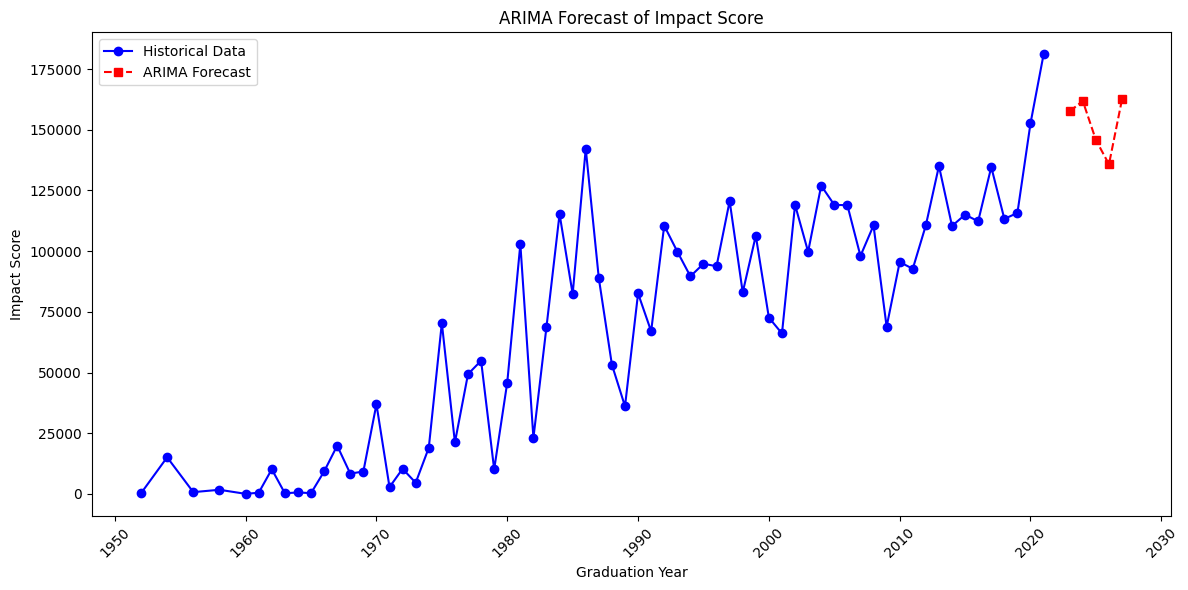


Detailed Forecast:
Year 2022: 157600.33
Year 2023: 161878.43
Year 2024: 145821.03
Year 2025: 135774.13
Year 2026: 162591.91


In [ ]:
# ARIMA model
from statsmodels.tsa.arima.model import ARIMA
# Prepare the data for ARIMA
grouped = df_filtered.groupby('años de graduación')[
    'impact_score'].sum().reset_index()
# Convert years to datetime format
grouped['años de graduación'] = pd.to_datetime(
    grouped['años de graduación'], format='%Y', errors='coerce')
# Set the index to the graduation year
grouped.set_index('años de graduación', inplace=True)
# Ensure the index is sorted
grouped.sort_index(inplace=True)
print("Grouped Data for ARIMA:")
print(grouped.head())
# Fit the ARIMA model
model = ARIMA(grouped['impact_score'], order=(0, 1, 5))
model_fit = model.fit()
# Make predictions
# for each year in the next 5 years
forecast = model_fit.forecast(steps=5)
# Print the forecasted values
print("ARIMA Forecast for the next 5 years:")
print(forecast)
# Create future dates for forecasting
last_date = grouped.index[-1]
future_dates = pd.date_range(
    start=last_date + pd.DateOffset(years=1), periods=5, freq='YE')

plt.figure(figsize=(12, 6))
# Plot historical data using the index (which is now the datetime)
plt.plot(grouped.index, grouped['impact_score'],
         label='Historical Data', color='blue', marker='o')

# Plot forecast
plt.plot(future_dates, forecast,
         label='ARIMA Forecast', color='red', marker='s', linestyle='--')

plt.title('ARIMA Forecast of Impact Score')
plt.xlabel('Graduation Year')
plt.ylabel('Impact Score')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('arima_forecast_impact_score.png')
plt.show()

# Print the forecast with corresponding years
print("\nDetailed Forecast:")
for i, (date, value) in enumerate(zip(future_dates, forecast)):
    print(f"Year {date.year}: {value:.2f}")

SVR Mean Squared Error: 922956546.14998
SVR R-squared: 0.7468574995742883


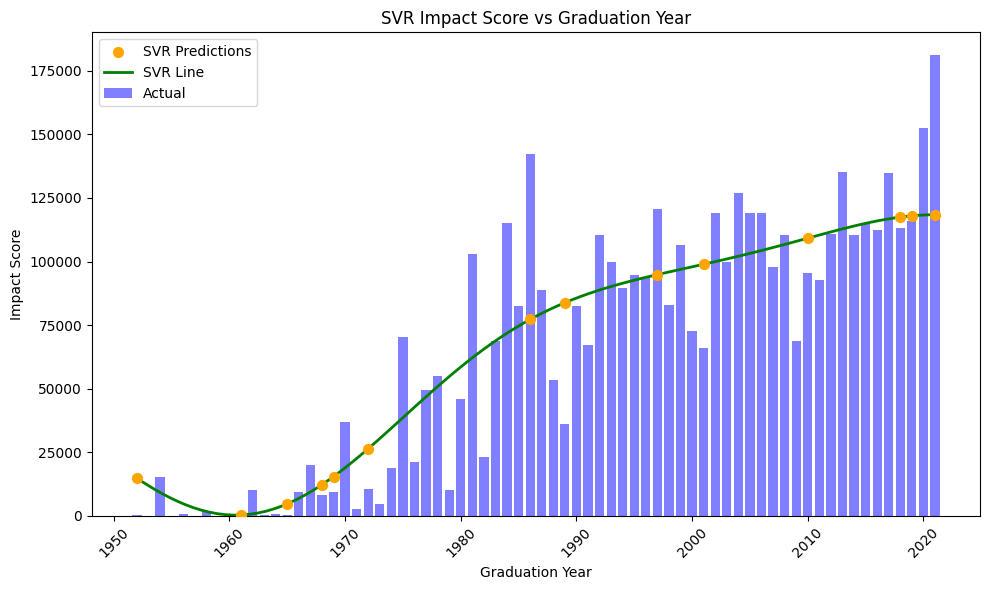

In [88]:
# Support Vector Regression (SVR)
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

# Prepare the data for SVR - use year values instead of datetime
grouped_reset = grouped.reset_index()
grouped_reset['year'] = grouped_reset['años de graduación'].dt.year

X = grouped_reset['year'].values.reshape(-1, 1)
y = grouped_reset['impact_score'].values

# Scale the features for better SVR performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)

# Create and fit the SVR model
svr_model = SVR(kernel='rbf', C=60000, gamma='scale', epsilon=0.1)
svr_model.fit(X_train, y_train)

# Make predictions
y_svr_pred = svr_model.predict(X_test)

# Evaluate the SVR model
mse_svr = mean_squared_error(y_test, y_svr_pred)
r2_svr = r2_score(y_test, y_svr_pred)
print(f'SVR Mean Squared Error: {mse_svr}')
print(f'SVR R-squared: {r2_svr}')

# Plot the SVR results
plt.figure(figsize=(10, 6))

# Plot actual data as bars using year values
years = grouped_reset['year'].values
plt.bar(years, y, color='blue', alpha=0.5, label='Actual')

# Get corresponding years for test predictions
X_test_years = scaler.inverse_transform(X_test)
plt.scatter(X_test_years.flatten(), y_svr_pred, color='orange',
            s=50, label='SVR Predictions', zorder=5)

# Plot SVR line
X_range = np.linspace(years.min(), years.max(), 100).reshape(-1, 1)
X_range_scaled = scaler.transform(X_range)
y_svr_range_pred = svr_model.predict(X_range_scaled)
plt.plot(X_range.flatten(), y_svr_range_pred,
         color='green', linewidth=2, label='SVR Line')

plt.title('SVR Impact Score vs Graduation Year')
plt.xlabel('Graduation Year')
plt.ylabel('Impact Score')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Random Forest Mean Squared Error: 705907680.9731709
Random Forest R-squared: 0.8063882463625474


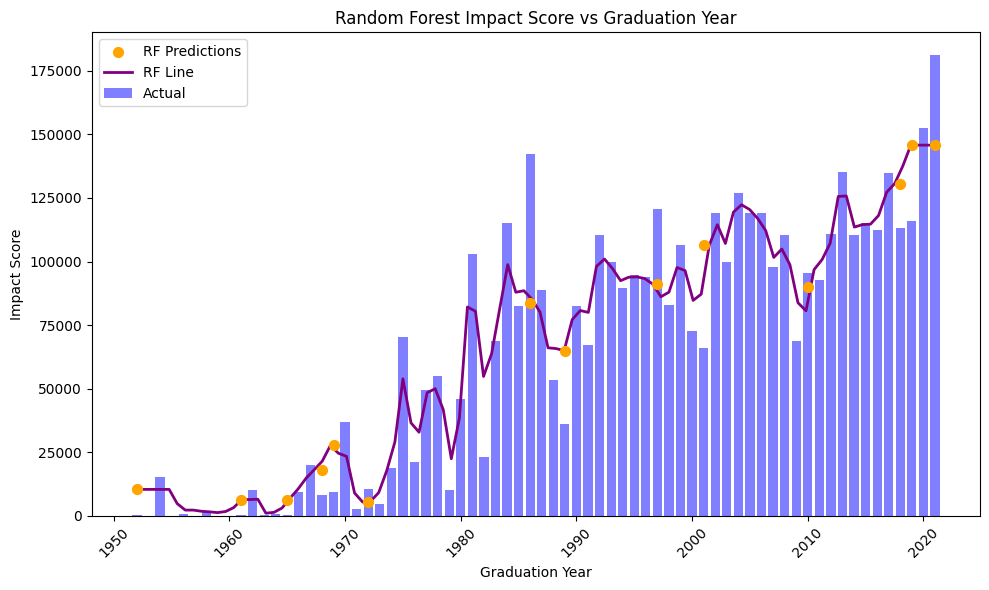


Model Comparison:
Linear Regression - Mean Squared Error: 991669812.63, R-squared: 0.73
SVR - Mean Squared Error: 922956546.15, R-squared: 0.75
Random Forest - Mean Squared Error: 705907680.97, R-squared: 0.81


In [ ]:
# Random Forest Regression
from sklearn.ensemble import RandomForestRegressor
# Create and fit the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train, y_train)
# Make predictions
y_rf_pred = rf_model.predict(X_test)
# Evaluate the Random Forest model
mse_rf = mean_squared_error(y_test, y_rf_pred)
r2_rf = r2_score(y_test, y_rf_pred)
print(f'Random Forest Mean Squared Error: {mse_rf}')
print(f'Random Forest R-squared: {r2_rf}')
# Plot the Random Forest results
plt.figure(figsize=(10, 6))
# Plot actual data as bars using year values
plt.bar(years, y, color='blue', alpha=0.5, label='Actual')
# Get corresponding years for test predictions
X_test_years = scaler.inverse_transform(X_test)
plt.scatter(X_test_years.flatten(), y_rf_pred, color='orange',
            s=50, label='RF Predictions', zorder=5)
# Plot Random Forest line
X_range = np.linspace(years.min(), years.max(), 100).reshape(-1, 1)
X_range_scaled = scaler.transform(X_range)
y_rf_range_pred = rf_model.predict(X_range_scaled)
plt.plot(X_range.flatten(), y_rf_range_pred,
         color='purple', linewidth=2, label='RF Line')
plt.title('Random Forest Impact Score vs Graduation Year')
plt.xlabel('Graduation Year')
plt.ylabel('Impact Score')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Compare models
models = {
    'Linear Regression': (mse, r2),
    'SVR': (mse_svr, r2_svr),
    'Random Forest': (mse_rf, r2_rf)
}
print("\nModel Comparison:")
for model_name, (mse_value, r2_value) in models.items():
    print(f"{model_name} - Mean Squared Error: {mse_value:.2f}, R-squared: {r2_value:.2f}")

In [ ]:
# Now for the final part: Deep Learning
# Temporal CNNs
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Flatten, Dropout
# Prepare the data for CNN
X_cnn = grouped_reset['year'].values.reshape(-1, 1, 1)  # Reshape for CNN
y_cnn = grouped_reset['impact_score'].values
# Split the data into training and testing sets
X_cnn_train, X_cnn_test, y_cnn_train, y_cnn_test = train_test_split(
    X_cnn, y_cnn, test_size=0.2, random_state=42)
# Create the CNN model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=64, kernel_size=1,
              activation='relu', input_shape=(1, 1)))
cnn_model.add(Dropout(0.2))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(1))  # Output layer
# Compile the model
cnn_model.compile(optimizer='adam', loss='mean_squared_error')
# Fit the model
cnn_model.fit(X_cnn_train, y_cnn_train, epochs=100, batch_size=16, verbose=1)
# Make predictions
y_cnn_pred = cnn_model.predict(X_cnn_test)
# Evaluate the CNN model
mse_cnn = mean_squared_error(y_cnn_test, y_cnn_pred)
r2_cnn = r2_score(y_cnn_test, y_cnn_pred)
print(f'CNN Mean Squared Error: {mse_cnn}')
print(f'CNN R-squared: {r2_cnn}')
# Plot the CNN results
plt.figure(figsize=(10, 6))
# Plot actual data as bars using year values
plt.bar(years, y, color='blue', alpha=0.5, label='Actual')
# Get corresponding years for test predictions
X_cnn_test_years = scaler.inverse_transform(X_cnn_test.reshape(-1, 1))
plt.scatter(X_cnn_test_years.flatten(), y_cnn_pred, color='orange',
            s=50, label='CNN Predictions', zorder=5)
# Plot CNN line
X_range = np.linspace(years.min(), years.max(), 100).reshape(-1, 1, 1)
X_range_scaled = scaler.transform(X_range.reshape(-1, 1)).reshape(-1, 1, 1)
y_cnn_range_pred = cnn_model.predict(X_range_scaled)
plt.plot(X_range.flatten(), y_cnn_range_pred,
         color='cyan', linewidth=2, label='CNN Line')
plt.title('CNN Impact Score vs Graduation Year')
plt.xlabel('Graduation Year')
plt.ylabel('Impact Score')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

ImportError: Traceback (most recent call last):
  File "C:\Users\iwell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.